In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.io import read_image, ImageReadMode
from PIL import Image
import os
import json
import pickle
import numpy as np

In [2]:
class RefCocoG_Dataset(Dataset):
    full_annotations = None

    def __init__(self, root_dir, annotations_f, instances_f, split='train', transform=None, target_transform=None) -> None:
        super().__init__()

        self.root_dir = root_dir
        self.annotations_f = annotations_f
        self.instances_f = instances_f

        self.split = split

        self.transform = transform
        self.target_transform = target_transform

        self.get_annotations()
        self.image_names = list([
            self.annotations[id]['image']['actual_file_name']
            for id in self.annotations
        ])

    def get_annotations(self):
        if RefCocoG_Dataset.full_annotations:
            self.annotations = dict(filter(lambda match: match[1]['image']['split'] == self.split, RefCocoG_Dataset.full_annotations.items()))
            return

        # Load pickle data
        with open(os.path.join(self.root_dir, 'annotations', self.annotations_f), 'rb') as file:
            self.data = pickle.load(file)

        # Load instances
        with open(os.path.join(self.root_dir, 'annotations', self.instances_f), 'rb') as file:
            self.instances = json.load(file)

        # Match data between the two files and build the actual dataset
        self.annotations = {}

        images_actual_file_names = {}
        for image in self.instances['images']:
            images_actual_file_names[image['id']] = image['file_name']

        for image in self.data:
            if image['ann_id'] not in self.annotations:
                self.annotations[image['ann_id']] = {}

            self.annotations[image['ann_id']]['image'] = image
            self.annotations[image['ann_id']]['image']['actual_file_name'] = images_actual_file_names[image['image_id']]

        for annotation in self.instances['annotations']:
            if annotation['id'] not in self.annotations:
                continue

            self.annotations[annotation['id']]['annotation'] = annotation

        # Keep only samples from the given split
        RefCocoG_Dataset.full_annotations = self.annotations
        self.annotations = dict(filter(lambda match: match[1]['image']['split'] == self.split, self.annotations.items()))

    def __len__(self):
        # Return the number of images
        return len(self.image_names)

    def corner_size_to_corners(self, bounding_box):
        """
        Transform (top_left_x, top_left_y, width, height) bounding box representation
        into (top_left_x, top_left_y, bottom_right_x, bottom_right_y)
        """

        return [
            bounding_box[0],
            bounding_box[1],
            bounding_box[0] + bounding_box[2],
            bounding_box[1] + bounding_box[3]
        ]

    def __getitem__(self, idx):
        # Get the image name at the given index
        image_name = self.image_names[idx]

        # Load the image file as a PIL image
        image = Image.open(os.path.join(self.root_dir, 'images', image_name)).convert('RGB')
        
        image_id = list(self.annotations)[idx]

        # Get the caption for the image
        prompts = [
            prompt['sent'] for prompt in self.annotations[image_id]['image']['sentences']
        ]

        # Get the bounding box for the prompts for the image
        bounding_box = self.corner_size_to_corners(self.annotations[image_id]['annotation']['bbox'])

        # Apply the transform if given
        if self.transform:
            image = self.transform(image)

        sample = [
            image,
            bounding_box,
            prompts,
        ]

        # Return the sample as a list
        return sample

In [3]:
# Load the dataset with the three splits

dataset_train = RefCocoG_Dataset('refcocog', 'refs(umd).p', 'instances.json', split='train')
dataset_val = RefCocoG_Dataset('refcocog', 'refs(umd).p', 'instances.json', split='val')
dataset_test = RefCocoG_Dataset('refcocog', 'refs(umd).p', 'instances.json', split='test')

dataset_splits = [
    dataset_train,
    dataset_val,
    dataset_test
]

In [4]:
# In order to be able to move lists of objects around (especially lists of
# PIL Images, rather than tensors), we need a custom collation function.
# This ensures we can feed the original images to the pipeline, rather
# than tensor-transformed (with scaling, cropping, etc.) versions.

def collate_differently_sized_prompts(batch):
    images = [item[0] for item in batch]
    bboxes = [item[1] for item in batch]
    prompts = [item[2] for item in batch]
    
    return list(images), list(bboxes), list(prompts)

def get_data(dataset_splits, batch_size=64, test_batch_size=256, num_workers=0):
    training_data = dataset_splits[0]
    validation_data = dataset_splits[1]
    test_data = dataset_splits[2]

    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True, drop_last=True, collate_fn=collate_differently_sized_prompts, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False, collate_fn=collate_differently_sized_prompts, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False, collate_fn=collate_differently_sized_prompts, num_workers=num_workers)

    return train_loader, val_loader, test_loader

In [5]:
train_loader, val_loader, test_loader = get_data(dataset_splits, batch_size=64, test_batch_size=64, num_workers=0)

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") # First GPU
else:
    device = 'cpu'

In [7]:
import torch

def cosine_similarity(a: torch.Tensor, b: torch.Tensor, keep_on_same_device=False):
    """
    Cosine Similarity

    Normalizes both tensors a and b. Returns <b, a.T> (inner product).
    """

    a_norm = a / a.norm(dim=-1, keepdim=True)
    b_norm = b / b.norm(dim=-1, keepdim=True)

    similarity = (b_norm @ a_norm.T)

    if keep_on_same_device:
        return similarity
    
    return similarity.cpu()

In [8]:
import torch.nn as nn

class Evaluator(nn.Module):
    def __init__(self, device=None, models=None, preprocesses=None) -> None:
        super().__init__()
        
        if device:
            self.device = device
        else:
            self.device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        
        if not models or not preprocesses:
            raise ValueError('Models and preprocesses for CLIP model should be provided')

        self.models = models
        self.preprocesses = preprocesses

        self.clip_backbones = list(self.models.keys())

    def forward(self, indices, images, gt_bounding_boxes, pred_bounding_boxes):
        self.device = indices.device
        if indices.is_cuda:
            self.device_index = int(str(self.device)[-1])
        else:
            self.device_index = 0

        # -- Getting the right data and moving it to the correct device --

        # Images remain on the CPU because they are PIL Images, not Tensors
        # Converting to Tensors leads to errors with YOLO
        images = [images[i] for i in indices]

        gt_bounding_boxes = [torch.tensor(gt_bounding_boxes[i]).unsqueeze(0) for i in indices]
        pred_bounding_boxes = [torch.tensor(pred_bounding_boxes[i]) for i in indices]
        
        pred_crops = [self.get_cropped_bounding_boxes(image, bbox_list) for image, bbox_list in zip(images, pred_bounding_boxes)]
        gt_crops = [self.get_cropped_bounding_boxes(image, bbox, len(pred_bboxes)) for image, bbox, pred_bboxes in zip(images, gt_bounding_boxes, pred_bounding_boxes)]

        # Store overall results across all the provided backbones
        overall_results = []

        with torch.no_grad():
            for backbone in self.clip_backbones:
                preprocessed_gt_crops = torch.stack([self.preprocesses[backbone][self.device_index](image) for sample in gt_crops for image in sample]).to(self.device)
                preprocessed_pred_crops = torch.stack([self.preprocesses[backbone][self.device_index](image) for sample in pred_crops for image in sample]).to(self.device)

                gt_crop_features = self.models[backbone][self.device_index].encode_image(preprocessed_gt_crops)
                pred_crop_features = self.models[backbone][self.device_index].encode_image(preprocessed_pred_crops)

                result = cosine_similarity(gt_crop_features, pred_crop_features, keep_on_same_device=True)
                result = torch.diagonal(result)
                overall_results.append(result)
        
        # Computing an average for each column
        overall_results = torch.stack(overall_results).mean(dim=0)

        return overall_results

    def get_cropped_bounding_boxes(self, image, bounding_boxes, repeat=1):
        cropped_bounding_boxes = []
        
        if bounding_boxes is None:
            return [image] * repeat

        for bounding_box in bounding_boxes:
            cropped_img = image.crop((bounding_box[0].item(), bounding_box[1].item(), bounding_box[2].item(), bounding_box[3].item()))
            cropped_bounding_boxes += [cropped_img] * repeat
        
        if len(cropped_bounding_boxes) == 0:
            return [image] * repeat

        return cropped_bounding_boxes

In [9]:
from torchvision.ops import box_iou

def iou_metric(bounding_boxes, ground_truth_bounding_boxes):
    """
    Localization Accuracy Metric

    Intersection over Union (IoU) is a common metric measure for localization accuracy.
    """

    if not torch.is_tensor(ground_truth_bounding_boxes):
        ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes)
    ground_truth_bounding_boxes = ground_truth_bounding_boxes.unsqueeze(0).to(device)

    return box_iou(bounding_boxes, ground_truth_bounding_boxes)

def cosine_similarity_metric(bounding_boxes, ground_truth_bounding_boxes):
    """
    Cosine Similarity Metric

    Cosine similarity is a common metric measure for semantic similarity.
    This measures the cosine similarity between the bounding boxes considered
    as sets of points.
    """

    if not torch.is_tensor(ground_truth_bounding_boxes):
        ground_truth_bounding_boxes = torch.tensor(ground_truth_bounding_boxes)
    ground_truth_bounding_boxes = ground_truth_bounding_boxes.to(device)
    
    return cosine_similarity(bounding_boxes, ground_truth_bounding_boxes)

def selected_area_cosine_similarity_metric(images, ground_truth_bounding_boxes, pred_bounding_boxes, evaluator_model):
    """
    Cosime Similarity between the embedding of the crops Metric

    Cosine similarity is a common metric measure for semantic similarity.
    This measures the cosine similarity between the embeddings of the areas
    as cropped by the bounding boxes.
    """

    pred_bounding_boxes = [bbox.cpu().numpy() for bbox in pred_bounding_boxes]
    indices = torch.tensor(list(range(len(pred_bounding_boxes)))).to(device)
    
    return evaluator_model(indices, images, ground_truth_bounding_boxes, pred_bounding_boxes)

In [10]:
accuracy_iou_threshold = 0.5

In [11]:
def test_model(data_loader, model, evaluator_model, device, verbose=False):
    IoUs = []
    cosine_similarities = []
    
    for batch_idx, (images, gt_bounding_boxes, prompts) in enumerate(data_loader):
        if verbose:
            print(f'-- Batch index: {batch_idx} --')

        # Run the model
        indices = torch.tensor(list(range(len(images)))).to(device)
        outputs = model(indices, images, prompts)

        # Group the outputs by sample, since each sample may have multiple
        # prompts which were treated independently of one another, thus
        # generating multiple bounding boxes.

        outputs_grouped_by_sample = []
        outputs_idx = 0
        prompts_idx = 0
        while True:
            if not prompts_idx < len(images):
                break

            outputs_grouped_by_sample.append(
                outputs[outputs_idx : outputs_idx + len(prompts[prompts_idx])]
            )

            outputs_idx += len(prompts[prompts_idx])
            prompts_idx += 1

        cosine_similarities += selected_area_cosine_similarity_metric(images, gt_bounding_boxes, outputs_grouped_by_sample, evaluator_model)
        
        for output_bboxes, gt_bboxes in zip(outputs_grouped_by_sample, gt_bounding_boxes):
            """
            There is one output bounding box for each prompt given in input.
            Note that each prompt for a given input is actually a list of prompts,
            therefore it can contain an arbitrary number of promps. Hence, there is
            a bounding box for each one of them.
            """
            
            result_ious = iou_metric(output_bboxes, gt_bboxes)
            for iou in result_ious:
                IoUs.append(iou)

    IoUs_to_cpu = np.array([tensor.item() if torch.is_tensor(tensor) else 0 for tensor in IoUs])
    mIoU = np.nanmean(IoUs_to_cpu)

    counter = np.sum([1 if iou >= accuracy_iou_threshold else 0 for iou in IoUs_to_cpu])
    accuracy = counter / len(IoUs)

    cosine_similarities_to_cpu = np.array([tensor.item() if torch.is_tensor(tensor) else 0 for tensor in cosine_similarities])
    m_cos_sim = np.nanmean(cosine_similarities_to_cpu)

    print('--- Metrics ---')
    print(f'Mean Intersection over Union (mIoU): {mIoU}')
    print(f'Accuracy: {accuracy}')
    print(f'Mean Cosine Similarity: {m_cos_sim}')

    return mIoU, accuracy, m_cos_sim

In [24]:
if torch.cuda.is_available():
    yolo_models = [torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(f'cuda:{i}') for i in range(torch.cuda.device_count())]
else:
    yolo_models = [torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(device)]

Using cache found in /Users/marco/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-4 Python-3.11.1 torch-2.0.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [25]:
import clip

clip_backbones = ['RN50x16']

models, preprocesses = {}, {}

for clip_backbone in clip_backbones:
    models[clip_backbone] = []
    preprocesses[clip_backbone] = []

    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            model, preprocess = clip.load(clip_backbone, device=f'cuda:{i}')
            
            models[clip_backbone].append(model)
            preprocesses[clip_backbone].append(preprocess)
    else:
        model, preprocess = clip.load(clip_backbone, device=device)
        models[clip_backbone].append(model)
        preprocesses[clip_backbone].append(preprocess)

In [224]:
import torch
import torch.nn as nn
import clip
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
from matplotlib import pyplot as plt

%matplotlib inline

class ColorsBackgroundModel(nn.Module):
    def __init__(self, device=None, models=None, preprocesses=None, yolo_models=None, text_features_bias=None) -> None:
        """
        Initialize a ColorsBackgroundModel. Note that it does not actually work, as it acts as an abstract class, which
        has to be subclassed in order to work properly with different YOLO versions.
        """

        super().__init__()
        
        if device:
            self.device = device
        else:
            self.device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        
        if not models or not preprocesses:
            raise ValueError('Models and preprocesses for CLIP model should be provided')

        self.models = models
        self.preprocesses = preprocesses

        self.clip_backbones = list(self.models.keys())
        
        if not yolo_models:
            raise ValueError('Models for YOLO should be provided')
        self.yolo_models = yolo_models

        # De-biasing features
        if not text_features_bias:
            self.text_features_bias = {}
            for backbone in self.clip_backbones:
                self.text_features_bias[backbone] = None
        else:
            self.text_features_bias = text_features_bias

    def forward(self, indices, images, prompts_list):
        self.device = indices.device
        if indices.is_cuda:
            self.device_index = int(str(self.device)[-1])
        else:
            self.device_index = 0

        # -- Getting the right data and moving it to the correct device --

        # Images remain on the CPU because they are PIL Images, not Tensors
        # Converting to Tensors leads to errors with YOLO
        images = [images[i] for i in indices]

        prompts_list = [prompts_list[i] for i in indices]
        # prompts_list = self.update_prompts_with_this_is(prompts_list)
        prompts_list, axis = self.update_prompts(prompts_list)
        # prompts_tensor = [[clip.tokenize(group_of_prompts).to(self.device) for group_of_prompts in prompt_list] for prompt_list in prompts_list]
        prompts_tensor = [clip.tokenize(prompt_list).to(self.device) for prompt_list in prompts_list]

        # -- Actual processing --

        bounding_boxes = self.get_bounding_boxes(images)

        # It contains the predicted bounding box for each image for each prompt
        # Then, it is a list of length len(images) and for each entry there is a
        # list with len(prompts[i]), where i is the i-th image 
        overall_outputs = []

        with torch.no_grad():
            for idx, prompts_tensor_for_sample in enumerate(prompts_tensor):
                # for prompt_tensor in prompts_tensor_for_sample:
                # Image crops
                image_crops, bounding_boxes[idx] = self.get_visual_prompts(images[idx], bounding_boxes[idx], spatial_axis=axis[idx][0])

                preprocessed_image_crops = {}
                for backbone in self.clip_backbones:
                    preprocessed_image_crops[backbone] = torch.stack([self.preprocesses[backbone][self.device_index](image) for image in image_crops]).to(self.device)

                similarities = {}
                for backbone in self.clip_backbones:
                    pic_batches = np.array_split(range(len(preprocessed_image_crops[backbone])), len(preprocessed_image_crops[backbone]))#// self.visual_augmentation)
                    
                    visual_features = []
                    for pic_batch in pic_batches:
                        visual_features.append(self.models[backbone][self.device_index].encode_image(preprocessed_image_crops[backbone][pic_batch]))
                    visual_features = torch.cat(visual_features)

                    text_features = self.models[backbone][self.device_index].encode_text(prompts_tensor_for_sample)

                    if self.text_features_bias[backbone] is not None:
                        text_features = torch.cat([text_features, self.text_features_bias[backbone].to(self.device)])

                    similarities[backbone] = cosine_similarity(visual_features, text_features)


                similarity = torch.empty_like(similarities[self.clip_backbones[0]])
                for prompt_idx in range(similarity.shape[0]):
                    for proposal_idx in range(similarity.shape[1]):
                        similarity[prompt_idx, proposal_idx] = torch.mean(torch.stack([
                            similarities[backbone][prompt_idx, proposal_idx] for backbone in self.clip_backbones
                        ]))


                # average = similarity.mean(dim=0)
                # scores = (similarity - average)[range(len(prompt_tensor))]
                scores = similarity[range(len(prompts_tensor_for_sample))]

                final_scores = torch.empty((scores.shape[0], scores.shape[1]))# // self.visual_augmentation))

                for prompt_idx in range(final_scores.shape[0]):
                    for final_score_idx, proposal_idx in enumerate(range(0, scores.shape[1], 1)):#self.visual_augmentation)):
                        final_scores[prompt_idx, final_score_idx] = torch.max(torch.stack([
                            scores[prompt_idx, proposal_idx + i] for i in range(1)#self.visual_augmentation)
                        ]))

                
                _, max_indices = final_scores.max(dim=-1)
                try:
                    for max_idx in max_indices:
                        overall_outputs.append(
                            (bounding_boxes[idx][max_idx, 0:4]).to(self.device)
                        )
                except:
                    for max_idx in max_indices:
                        overall_outputs.append(
                            torch.tensor((0, 0, images[idx].size[0], images[idx].size[1])).to(self.device)
                        )

        return torch.stack(overall_outputs)

    def update_prompt(self, prompt, color):
        return [
            # f'{prompt}. The image has a {color} background',
            # f'{color}. {prompt}',
            f'A {color} picture of {prompt}'
        ]

    def get_color(self, prompt):
        if 'left' in prompt:
            return 'blue', 0
        if 'right' in prompt:
            return 'red', 0
        if 'above' in prompt:
            return 'blue', 1
        if 'below' in prompt:
            return 'red', 1
        
        return None, None

    # def update_prompts(self, prompts):
    #     updated_prompts = []
    #     axis = []

    #     for sample in prompts:
    #         groups_of_prompts_for_sample = []
    #         axis_for_sample = []
    #         for prompt in sample:
    #             color, direction = self.get_color(prompt)

    #             if color:
    #                 prompts_for_sample = self.update_prompt(prompt, color)
    #             else:
    #                 prompts_for_sample = [prompt]

    #             axis_for_sample += [direction]
    #             groups_of_prompts_for_sample.append(prompts_for_sample)

    #         updated_prompts.append(groups_of_prompts_for_sample)
    #         axis.append(axis_for_sample)

    #     print(updated_prompts)

    #     return updated_prompts, axis

    def update_prompts(self, prompts):
        updated_prompts = []
        axis = []

        for sample in prompts:
            prompts_for_sample = []
            axis_for_sample = []
            for prompt in sample:
                color, direction = self.get_color(prompt)

                if color:
                    prompts_for_sample += self.update_prompt(prompt, color)
                else:
                    prompts_for_sample += [prompt]

                axis_for_sample += [direction]

            updated_prompts.append(prompts_for_sample)
            axis.append(axis_for_sample)

        print(updated_prompts)

        return updated_prompts, axis

    def update_prompts_with_this_is(self, prompts):
        """
        Update the textual prompts by adding 'This is' at the beginning.
        This seems to help in guiding CLIP to focus on the correct part
        of the visual prompt.
        """

        return [['This is ' + prompt for prompt in sample] for sample in prompts]

    def get_bounding_boxes(self, pil_images):
        pass

    def get_image_with_marker(self, image, bbox, stroke_color='red', stroke_width=1):
        """
        Add a visual marker to the image at the position specified by the
        bounding box (bbox), which is expected to be in the format
        (top_left_x, top_left_y, bottom_right_x, bottom_right_y).
        """
        
        result = image.copy()
        draw = ImageDraw.Draw(result)
        draw.ellipse(bbox, outline=stroke_color, width=stroke_width)
        
        return result
    
    def get_image_with_marker_and_blur(self, image, bbox, stroke_color='red', stroke_width=1, blur_radius=1):
        """
        Add a visual marker to the image at the position specified by the
        bounding box (bbox), which is expected to be in the format
        (top_left_x, top_left_y, bottom_right_x, bottom_right_y).
        The background is then blurred.
        """
        
        result = image.filter(ImageFilter.GaussianBlur(radius=blur_radius))
        mask = Image.new('L', image.size, 0)
        draw = ImageDraw.Draw(mask)
        draw.rectangle(bbox, fill=255)
        result.paste(image, mask=mask)
        draw = ImageDraw.Draw(result)
        draw.ellipse(bbox, outline=stroke_color, width=stroke_width)
        
        return result

    def get_image_with_marker_and_grayscale(self, image, bbox, stroke_color='red', stroke_width=1):
        """
        Add a visual marker to the image at the position specified by the
        bounding box (bbox), which is expected to be in the format
        (top_left_x, top_left_y, bottom_right_x, bottom_right_y).
        The background is grayscaled.
        """
        
        result = image.convert('L').convert('RGB')
        mask = Image.new('L', image.size, 0)
        draw = ImageDraw.Draw(mask)
        draw.rectangle(bbox, fill=255)
        result.paste(image, mask=mask)
        draw = ImageDraw.Draw(result)
        draw.ellipse(bbox, outline=stroke_color, width=stroke_width)

        return result

    def get_image_with_marker_and_blur_grayscale(self, image, bbox, stroke_color='red', stroke_width=1, blur_radius=1):
        """
        Add a visual marker to the image at the position specified by the
        bounding box (bbox), which is expected to be in the format
        (top_left_x, top_left_y, bottom_right_x, bottom_right_y).
        The background is both grayscaled and blurred.
        """
        
        result = image.filter(ImageFilter.GaussianBlur(radius=blur_radius)).convert('L').convert('RGB')
        mask = Image.new('L', image.size, 0)
        draw = ImageDraw.Draw(mask)
        draw.rectangle(bbox, fill=255)
        result.paste(image, mask=mask)
        draw = ImageDraw.Draw(result)
        draw.ellipse(bbox, outline=stroke_color, width=stroke_width)

        return result

    def get_background_color(self, normalized_x, normalized_y, spatial_axis):
        """
        Spatial Axis:
        - 0 for horizontal
        - 1 for vertical
        """
        
        color = (0, 0, 0)

        if spatial_axis == 0:
            if normalized_x <= 0.35:
                color = (0, 0, 255)
            elif normalized_x > 0.67:
                color = (255, 0, 0)

        if spatial_axis == 1:
            if normalized_y <= 0.35:
                color = (0, 0, 255)
            elif normalized_y > 0.67:
                color = (255, 0, 0)

        return color

        # Left
        if normalized_x <= 0.35:
            # Top
            if normalized_y <= 0.33:
                color = (0, 0, 255) # Blue
            # Center
            elif normalized_y <= 0.67:
                color = (0, 255, 0) # Green
            # Bottom
            else:
                color = (139, 69, 19) # Brown
            
        # Center
        elif normalized_x <= 0.65:
            # Top
            if normalized_y <= 0.33:
                color = (255, 255, 0) # Yellow
            # Center
            elif normalized_y <= 0.67:
                color = (255, 0, 255) # Magenta
            # Bottom
            else:
                color = (0, 255, 255) # Cyan

        # Right
        else:
            # Top
            if normalized_y <= 0.33:
                color = (255, 0, 0) # Red
            # Center
            elif normalized_y <= 0.67:
                color = (0, 0, 0) # Black
            # Bottom
            else:
                color = (255, 255, 255) # White
        
        # Just to check this never happens
        return color

    def get_visual_prompts(self, image, bounding_boxes, spatial_axis=None):
        visual_prompts = []
        keep_bbox = []

        if bounding_boxes is None:
            return [image], bounding_boxes

        width, height = image.size

        for idx, bounding_box in enumerate(bounding_boxes if bounding_boxes is not None else []):
            bounding_box = (bounding_box[0].item(), bounding_box[1].item(), bounding_box[2].item(), bounding_box[3].item())

            # For the following line to work correctly bounding boxes should actually be removed from
            # YOLO's results, as that's what is actually used in the end
            # if (bounding_box[2] - bounding_box[0]) * (bounding_box[3] - bounding_box[1]) < (image.size[0] * image.size[1]) * 0.8:
            #     continue

            keep_bbox += [idx]

            if spatial_axis is None:
                visual_prompt = image.crop(bounding_box)
            else:
                color = self.get_background_color(
                    (bounding_box[2] + bounding_box[0]) / (2 * width),
                    (bounding_box[3] + bounding_box[1]) / (2 * height),
                    spatial_axis
                )

                visual_prompt = image.copy()
                draw = ImageDraw.Draw(visual_prompt)
                draw.rectangle((0, 0, width, height), fill=color)

                mask = Image.new('L', image.size, 0)
                draw = ImageDraw.Draw(mask)
                draw.rectangle(bounding_box, fill=255)
                visual_prompt.paste(image, mask=mask)

            fig, ax = plt.subplots()
            ax.imshow(visual_prompt)

            visual_prompts.append(visual_prompt)

        
        bounding_boxes = bounding_boxes[keep_bbox]

        if len(visual_prompts) == 0:
            # If no region proposal, return the whole image.
            # It is inserted as many times as each region would
            # be augmented to ensure consistency in the algorithm
            visual_prompts.append(image)

        return visual_prompts, bounding_boxes



class ColorsBackgroundModelYOLOv5(ColorsBackgroundModel):
    def get_bounding_boxes(self, pil_images):
        bounding_boxes = self.yolo_models[self.device_index](pil_images)
        return bounding_boxes.pred

class ColorsBackgroundModelYOLOv8(ColorsBackgroundModel):
    def get_bounding_boxes(self, pil_images):
        bounding_boxes = self.yolo_models[self.device_index].predict(pil_images, verbose=False)
        bounding_boxes = [torch.cat([box.xyxy for box in res.boxes]) if res.boxes else None for res in bounding_boxes]
        return bounding_boxes
    
# Instantiate the model
colors_bg_model = ColorsBackgroundModelYOLOv5(models=models, preprocesses=preprocesses, yolo_models=yolo_models)

# And make it work with multiple GPUs if they are available
if torch.cuda.device_count() > 1:
    colors_bg_model = torch.nn.DataParallel(colors_bg_model)

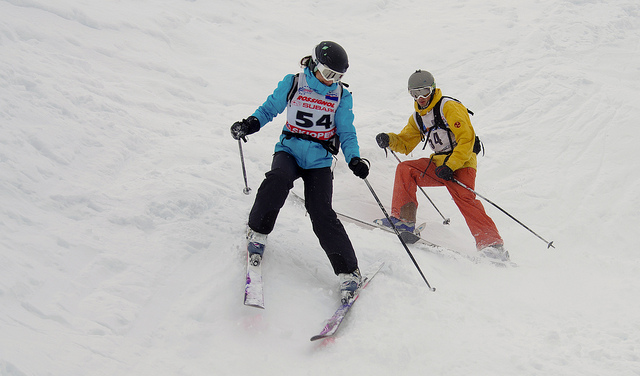

In [258]:
idx = 0
# idx = 17

images, gt_bboxes, prompts = next(iter(test_loader))
images = images[0+idx:1+idx]
prompts = prompts[0+idx:1+idx]
prompts = [[
    'the skiier on the right',
    # 'the skiier on the left'
]]
gt_bboxes = gt_bboxes[0+idx:1+idx]

indices = torch.tensor(list(range(len(images)))).to(device)

images[0]

[['A red picture of the skiier on the right']]


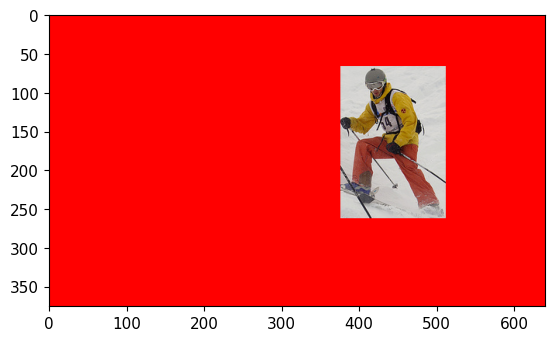

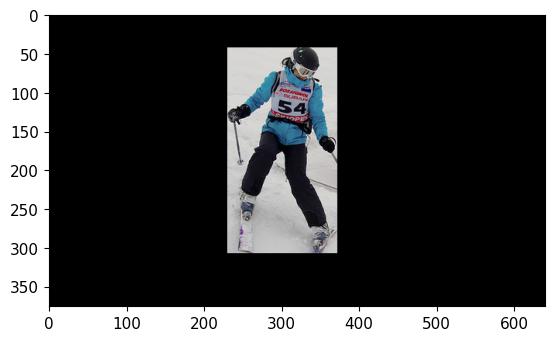

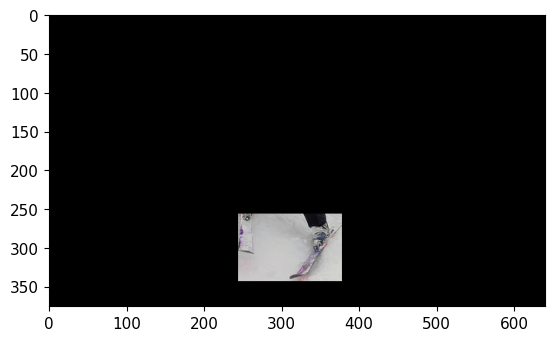

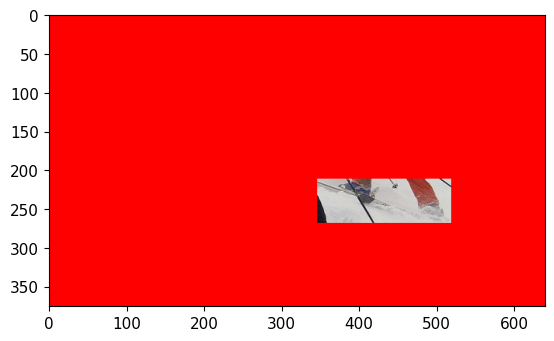

In [259]:
out = colors_bg_model(indices, images, prompts)

In [218]:
out

tensor([[ 43.78769, 172.82693, 196.29305, 352.17062],
        [ 43.78769, 172.82693, 196.29305, 352.17062]])

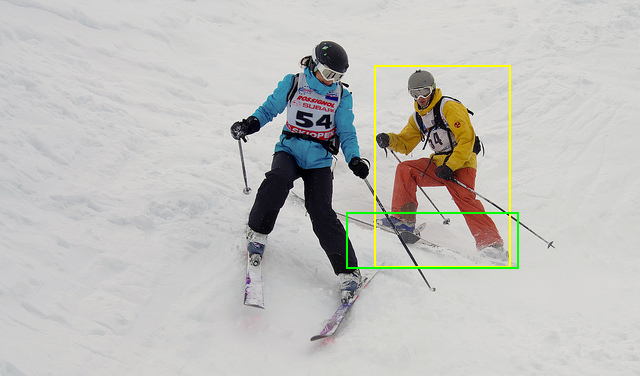

In [260]:
from PIL import ImageDraw

copy = images[0].copy()
draw = ImageDraw.Draw(copy)
draw.rectangle(gt_bboxes[0], outline=(255, 255, 0), width=2)
draw.rectangle(out[0].cpu().numpy(), outline=(0, 255, 0), width=2)
copy